# Demonstration

This notebook serves as a demonstration of the project's workflow from start to finish. Data obtained by the SQL query is provided in the [demo](../data/demo/review_query.csv) directory.

## Import modules

In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

%run .engine.py
engine = create_engine(LOGIN)

## Data Preparation

### Query the data

In [3]:
query = """
SELECT reviews.stars as stars, 
reviews.text as text, 
reviews.useful as useful, 
reviews.funny as funny, 
business.state as state,
business.categories as categories
FROM reviews
INNER JOIN business ON reviews.business_id = business.business_id
ORDER BY random()
LIMIT 100000
"""

df = pd.read_sql_query(query, engine)
df.shape

(100000, 6)

In [4]:
df.head()

,stars,text,useful,funny,state,categories
0,5.0,This salon is under new management and everyon...,0,0,AZ,Nail Salons;Beauty & Spas
1,5.0,I've eaten there a few times in the last month...,1,1,AZ,Food;Restaurants;Sandwiches;Chicken Wings;Food...
2,5.0,Beautiful flower arrangements at a very reason...,0,0,NV,Shopping;Florists;Flowers & Gifts
3,5.0,"Terrific service, efficient staff and always c...",0,0,AZ,Restaurants;Pizza;Italian;Nightlife;Bars
4,5.0,"Dr. Goldstein,\n\nI was seen by Dr Goldstein o...",0,0,AZ,Health & Medical;Dentists;Oral Surgeons;Period...


In [8]:
df.to_csv('../data/demo/reviews.csv', index=False)

### Check for nulls

In [5]:
df.isnull().sum().sum()

0

### Create feature columns

In [6]:
categories = ['Active Life', 'Arts & Entertainment', 'Automotive', 
            'Beauty & Spas', 'Education', 'Event Planning & Services' , 
            'Financial Services', 'Food', 'Health & Medical', 'Home Services', 
            'Hotels & Travel', 'Local Flavor', 'Local Services', 'Mass Media', 
            'Nightlife', 'Pets', 'Professional Services', 'Public Services & Government',
            'Real estate', 'Religious Organizations', 'Restaurants',
            'Shopping']

In [9]:
for i in categories:
    df[i] = df['categories'].map(lambda x: i in x).astype(int)

In [10]:
df.columns = df.columns.map(lambda x: x.lower().replace(' ','_').replace('&', 'and'))
df.drop(['categories'], 1, inplace=True)

In [11]:
df['review_length'] = df['text'].map(lambda x: len(x.split(' ')))

### Drop international reviews

In [12]:
states_to_keep = ['NV', 'AZ', 'ON', 'NC', 'OH', 'PA', 'WI', 'IL', 'SC']

In [13]:
df = df[df.state.isin(states_to_keep)]

## Text processing

In [14]:
import spacy
import textacy
from sklearn.feature_extraction.text import TfidfVectorizer

### Preprocessing, removing non-English reviews

In [15]:
df['processed'] = df['text'].map(lambda x: textacy.preprocess.preprocess_text(x, lowercase=True, 
                                                                                    no_urls=True, 
                                                                                    no_punct=True, 
                                                                                    no_numbers=True))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
def isEnglish(s):
    try:
        s.encode('ascii')
    except UnicodeEncodeError:
        return False
    else:
        return True

In [17]:
df['isEnglish'] = df['processed'].astype('str').astype('unicode').apply(lambda x: isEnglish(x) == True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
df.isEnglish.value_counts()

True     93837
False     1666
Name: isEnglish, dtype: int64

In [19]:
df = df[df.isEnglish == True]

### Tokenizing

In [20]:
nlp = textacy.load_spacy("en_core_web_sm", 
                         disable = ("tagger", "parser", "ner", "textcat"))

In [21]:
def token_filter(token): 
    return not (token.is_stop | len(token.text) <= 4)

In [22]:
docs = df['processed'].tolist()

In [23]:
filtered_tokens = []
for doc in nlp.pipe(docs, disable=['tagger', 'parser', 'ner', 'textcat']):
        tokens = [token.lemma_ for token in doc if token_filter(token)]
        filtered_tokens.append(tokens)

### Vectorizing

In [24]:
def identity(doc):
    return doc

In [25]:
vectorizer = TfidfVectorizer(analyzer='word', tokenizer=identity, preprocessor=identity, 
                             token_pattern=None, strip_accents='ascii', min_df=5, max_df=0.95,
                             max_features=10000, use_idf=True, sublinear_tf=True)

## Topic modeling

In [26]:
def print_topics(model, n_topics, n_terms):
    for topic_idx, top_terms in model.top_topic_terms(vectorizer.get_feature_names(), topics=n_topics, top_n=n_terms):
        print('topic', topic_idx, ':', '   '.join(top_terms))

In [33]:
doc_term_matrix = vectorizer.fit_transform(doc for doc in filtered_tokens)

In [ ]:
lsa = textacy.TopicModel('lsa', n_topics=325, random_state=1)
lsa.fit(doc_term_matrix)

In [36]:
doc_topic_matrix = lsa.transform(doc_term_matrix)

In [38]:
print_topics(lsa, range(20), 5)

topic 0 : numb   this   they   that   be
topic 1 : great   place   friendly   service   very
topic 2 : great   staff   friendly   service   recommend
topic 3 : service   very   back   order   will
topic 4 : very   staff   friendly   clean   recommend
topic 5 : place   this   recommend   will   definitely
topic 6 : pizza   always   they   order   their
topic 7 : pizza   numb   very   price   staff
topic 8 : numb   place   friendly   staff   this
topic 9 : price   recommend   service   highly   this
topic 10 : recommend   highly   numb   amaze   always
topic 11 : great   place   fry   staff   order
topic 12 : numb   price   will   definitely   back
topic 13 : amaze   numb   staff   make   your
topic 14 : they   sushi   their   delicious   drink
topic 15 : they   really   service   friendly   recommend
topic 16 : sushi   order   recommend   staff   great
topic 17 : amaze   be   sushi   staff   have
topic 18 : always   really   very   drink   price
topic 19 : here   breakfast   sandwich   

/opt/conda/lib/python3.6/site-packages/matplotlib/collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


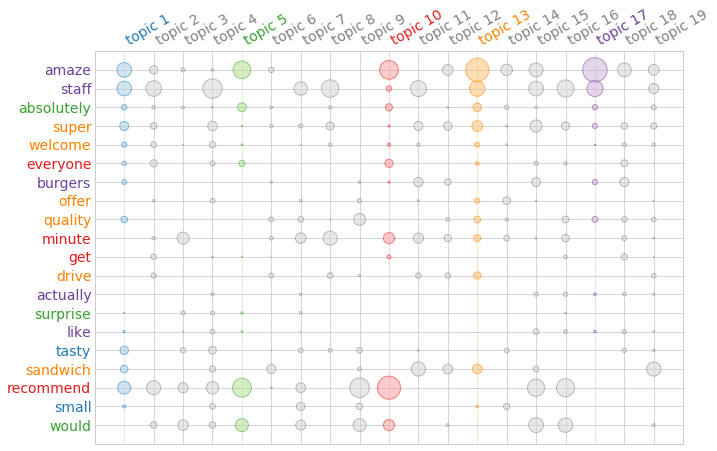

In [43]:
lsa.termite_plot(doc_term_matrix,
                       vectorizer.get_feature_names(), 
                       topics=[num for num in range(1, 20)],
                       highlight_topics=[1, 5, 10, 13, 17],
                       n_terms=20)

## Create feature matrix

In [46]:
df.drop(['text', 'useful', 'state', 'processed', 'isEnglish', 'real_estate'], 1, inplace=True)

In [49]:
left_matrix = df.values

In [51]:
right_matrix = doc_topic_matrix

In [52]:
left_matrix.shape, right_matrix.shape

((93837, 24), (93837, 325))

In [53]:
features = np.hstack((left_matrix, right_matrix))

## Get model predictions

In [54]:
import pickle

In [55]:
with open('../models/logisticreg.pkl', 'rb') as model:
    model = pickle.load(model)

In [56]:
model.predict(features)

array([1, 1, 1, ..., 1, 1, 1])